# Investigating GPA Trends of Math Instructors Compared to the Math Department as a Whole at UW Madison since 2006

This notebook uses data from the UW Madison database to complete hypothesis tests on each math teacher that has taught more than 15 sections graded on A-F scale.

$H_0$: The teacher's section mean GPA's are no different than that of the math department as a whole.

$H_A$: The teacher's section mean GPA's are higher or lower than that of the math department as a whole.

---

## Import necessary Python libraries and modules

In [1]:
from sqlalchemy import create_engine
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

## Query the database and create a dataframe of math_grades_clean

In [2]:
engine = create_engine('postgresql:///uw_madison')

In [3]:
df = pd.read_sql_query("""SELECT * FROM math_grades_clean;""", engine)

## Example analysis for a single instructor

instructor: 3089128
p-value: 0.8154550324988283


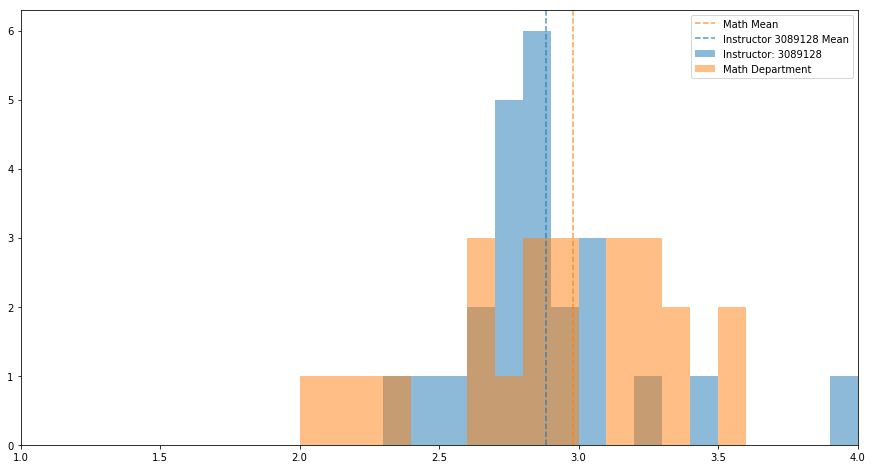

In [4]:
teacher = df.loc[df['instructor_id'] == '3089128']
teacher_dist = teacher['section_gpa']
pop_dist = np.random.choice(df['section_gpa'], size = len(teacher_dist), replace=False)
pval = stats.ttest_ind(teacher_dist, pop_dist, equal_var=False)[1]

print('instructor: 3089128')
print(f'p-value: {pval}')

fig, ax = plt.subplots(figsize = (15, 8))
ax.hist(teacher_dist, alpha = .5, label='Instructor: 3089128', range=(1, 4), bins=30)
ax.hist(pop_dist, alpha = .5, label='Math Department', range= (1, 4), bins=30)
ax.axvline(df['section_gpa'].mean(), color='#ff7f0e', alpha=.75, 
           label='Math Mean', linestyle='dashed')
ax.axvline(teacher_dist.mean(), color='#1f77b4', alpha=.75, 
           label='Instructor 3089128 Mean', linestyle='dashed')
ax.legend()
ax.set_xlim(1,4);

## For each instructor with more than 15 sections taught, complete hypothesis test. If there is a statistically significant difference in grading α=0.05 level, we log the p-value, and instructor

In [5]:
p_values = []
exceptional_instructors = []

for instructor in df['instructor_id'].unique():
    gpas = df.loc[df['instructor_id'] == instructor, 'section_gpa']
    if len(gpas) > 15:
        teacher_dist = gpas
        pop_dist = np.random.choice(df['section_gpa'], size=len(gpas), replace=False)
        pval = stats.ttest_ind(teacher_dist, pop_dist, equal_var=False)[1]
        p_values.append(pval)
        if pval <= .05:
            exceptional_instructors.append(instructor)

## List summary results from teacher analysis

In [6]:
print (f'% significantly different: {round(len(exceptional_instructors)/len(p_values),3)*100}')
print (f'number significantly different: {len(exceptional_instructors)}')

% significantly different: 20.599999999999998
number significantly different: 7


## Plot histogram for each instructor whose grading is statistically significantly different at a α=0.05 level from the Math department as a whole

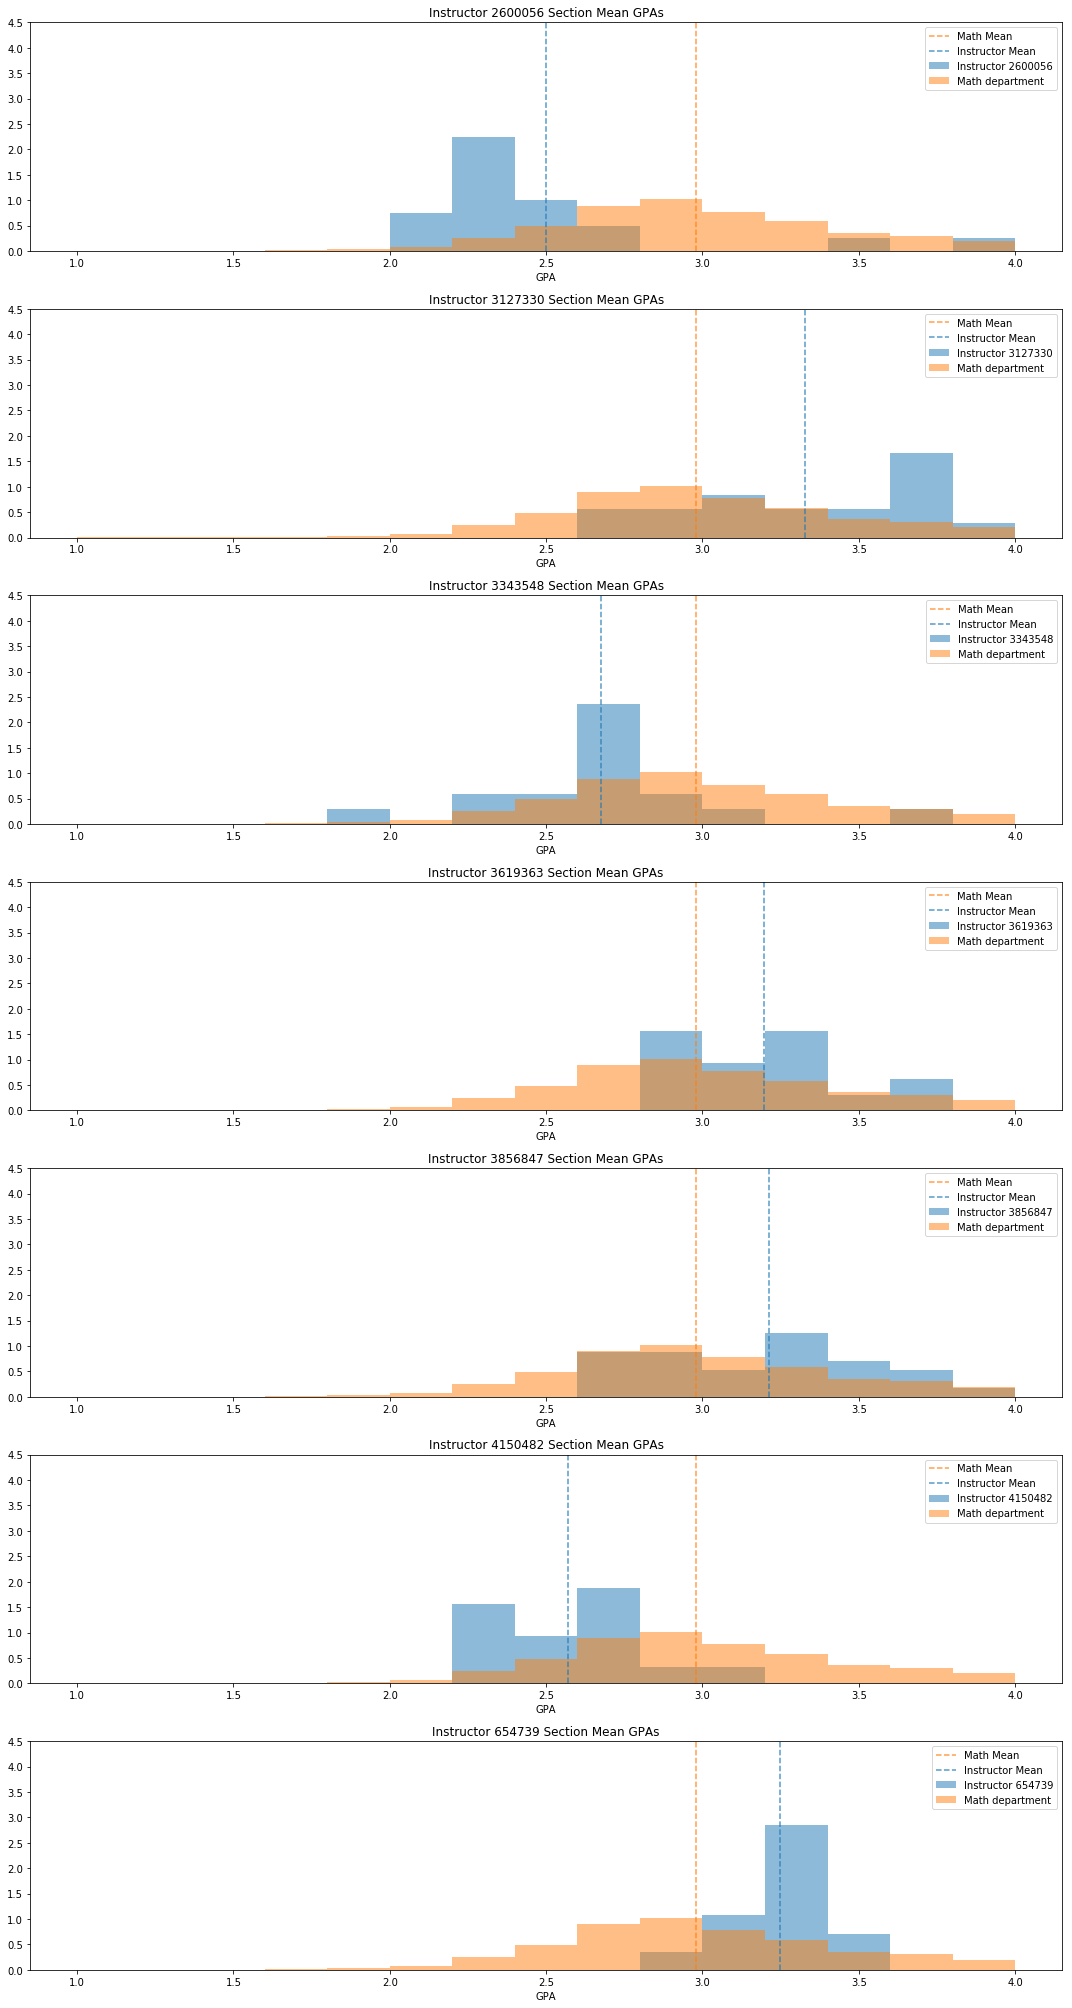

In [7]:
fig, ax = plt.subplots(nrows=len(exceptional_instructors), ncols=1, 
                       figsize = (15, len(exceptional_instructors)*4))
for row, instructor in enumerate(exceptional_instructors):
    ax[row].hist(df.loc[df['instructor_id']==instructor, 'section_gpa'], density=True,
                 alpha=0.5, bins=15, range=(1,4), label=f'Instructor {instructor}')
    ax[row].hist(df['section_gpa'], density=True,
                 alpha=0.5, bins=15, range=(1,4), label=f'Math department')
    ax[row].set_xlabel('GPA')
    ax[row].set_title(f'Instructor {instructor} Section Mean GPAs')
    ax[row].set_ylim((0,4.5))
    ax[row].axvline(df['section_gpa'].mean(), color='#ff7f0e', alpha=.75, 
                    label='Math Mean', linestyle='dashed')
    ax[row].axvline(df.loc[df['instructor_id']==instructor, 'section_gpa'].mean(), 
                    color='#1f77b4', alpha=.75, label='Instructor Mean', linestyle='dashed')
    ax[row].legend()
    
fig.tight_layout()

## Analysis

We reject the null hypothesis that there is no difference between the teacher and the math department as a whole for these instructors at a 95% confidence level.

For the remaining instructors, we do not reject the null hypothesis.

# Using Bonferroni correction

In [9]:
multipletests(p_values)

(array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False]),
 array([0.99922521, 0.00742816, 0.99994478, 0.94870458, 0.99323095,
        0.99994478, 0.99994478, 0.99994478, 0.99959345, 0.97101569,
        0.85016882, 0.59822283, 0.99994478, 0.99823601, 0.99823601,
        0.01924767, 0.99821066, 0.55861626, 0.99991242, 0.43112904,
        0.99994478, 0.8197046 , 0.83963939, 0.99184697, 0.00705957,
        0.99994034, 0.99994478, 0.99988145, 0.80893101, 0.99325242,
        0.83963939, 0.94870458, 0.99994478, 0.10505816]),
 0.0015074889008961367,
 0.0014705882352941176)

After applying the Bonferroni correction, we can see that we can reject the null hypothesis for most of the instructors, except for three.